# Zuber Analysis

## Introduction

In the bustling city of Chicago, the transportation landscape is dynamic and ever-evolving. Understanding the patterns and trends within the taxi industry is crucial for both service providers and consumers alike. In this project, we delve into a comprehensive analysis of taxi trip data in Chicago, aiming to uncover valuable insights into ride distribution, popular destinations, market dominance, and more. By leveraging advanced data analytics techniques, we seek to paint a detailed picture of Chicago's taxi ecosystem, shedding light on the key players, prominent dropoff locations, and factors influencing ride demand. Through this exploration, we aim to provide actionable insights that can inform business strategies, improve service efficiency, and enhance the overall taxi experience in the Windy City. Join us on this journey as we unravel the intricacies of Chicago's taxi industry and unearth the stories hidden within the data.

### Library and Data Import

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

In [5]:
try:
    trips_df = pd.read_csv('../datasets/project_sql_result_01.csv')
    dropoff_df = pd.read_csv('../datasets/project_sql_result_04.csv')
    loop_ohare_df = pd.read_csv('../datasets/project_sql_result_07.csv')
except FileNotFound as e:
    print(f'The following error occured when trying to load the file(s): [${e}]')
else:
    print(f'The files were loaded successfully')

The files were loaded successfully


## Data Exploration & Cleaning

In [6]:
trips_df.info()
print()
print()
dropoff_df.info()
print()
print()
loop_ohare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duratio

**Observations**

From the first glance, it appears that the data types in all three data frames are accurate, except for the `loop_ohare_df`, where the `start_ts` field is represented as an object instead of datetime. Additionally, we need to pay attention to the `duration_seconds` as they are usually not in float64 format.

The data also suggest that there are no missing values in either of the three DataFrames.

Additionally, I would like to create `duration_minutes` and `duration_hours` columns to help relate data a bit easier.

In [7]:
# Looking closer at the duration_seconds and start_ts fields.
loop_ohare_df.head(15)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
5,2017-11-11 04:00:00,Good,1320.0
6,2017-11-04 16:00:00,Bad,2969.0
7,2017-11-18 11:00:00,Good,2280.0
8,2017-11-11 14:00:00,Good,2460.0
9,2017-11-11 12:00:00,Good,2040.0


In [8]:
loop_ohare_df['duration_seconds'] = loop_ohare_df['duration_seconds'].astype('int64')
loop_ohare_df['start_ts'] = pd.to_datetime(loop_ohare_df['start_ts'])

In [9]:
# Creating two new columns to help visualize data easier

loop_ohare_df['duration_minutes'] = np.round((loop_ohare_df['duration_seconds'] / 60), 2)
loop_ohare_df['duration_hours'] = np.round((loop_ohare_df['duration_seconds'] / 3600), 2)

In [10]:
# Checking for duplicates

print(f'Duplicates in trips_df: {trips_df.duplicated().sum()}')
print(f'Duplicates in dropoff_df: {dropoff_df.duplicated().sum()}')
print(f'Duplicates in loop_ohare_df: {loop_ohare_df.duplicated().sum()}')

Duplicates in trips_df: 0
Duplicates in dropoff_df: 0
Duplicates in loop_ohare_df: 197


**Observations**

Duplicates definitely exist in the loop_ohare_df as rides can occur multiple times. Without unique identifiers in the dataset, distinguishing between duplicates of the same ride and distinct rides with identical locations becomes challenging.

In [11]:
loop_ohare_df

,start_ts,weather_conditions,duration_seconds,duration_minutes,duration_hours
0,2017-11-25 16:00:00,Good,2410,40.17,0.67
1,2017-11-25 14:00:00,Good,1920,32.00,0.53
2,2017-11-25 12:00:00,Good,1543,25.72,0.43
3,2017-11-04 10:00:00,Good,2512,41.87,0.70
4,2017-11-11 07:00:00,Good,1440,24.00,0.40
...,...,...,...,...,...
1063,2017-11-25 11:00:00,Good,0,0.00,0.00
1064,2017-11-11 10:00:00,Good,1318,21.97,0.37
1065,2017-11-11 13:00:00,Good,2100,35.00,0.58
1066,2017-11-11 08:00:00,Good,1380,23.00,0.38


## Data Analysis

In [12]:
top_10_dropoff_locations_df = dropoff_df.groupby('dropoff_location_name')['average_trips'].sum().sort_values(ascending=False).head(10).reset_index()
top_10_dropoff_locations_df['average_trips'] = np.round(top_10_dropoff_locations_df['average_trips'], 2)
top_10_dropoff_locations_df

,dropoff_location_name,average_trips
0,Loop,10727.47
1,River North,9523.67
2,Streeterville,6664.67
3,West Loop,5163.67
4,O'Hare,2546.90
5,Lake View,2420.97
6,Grant Park,2068.53
7,Museum Campus,1510.00
8,Gold Coast,1364.23
9,Sheffield & DePaul,1259.77


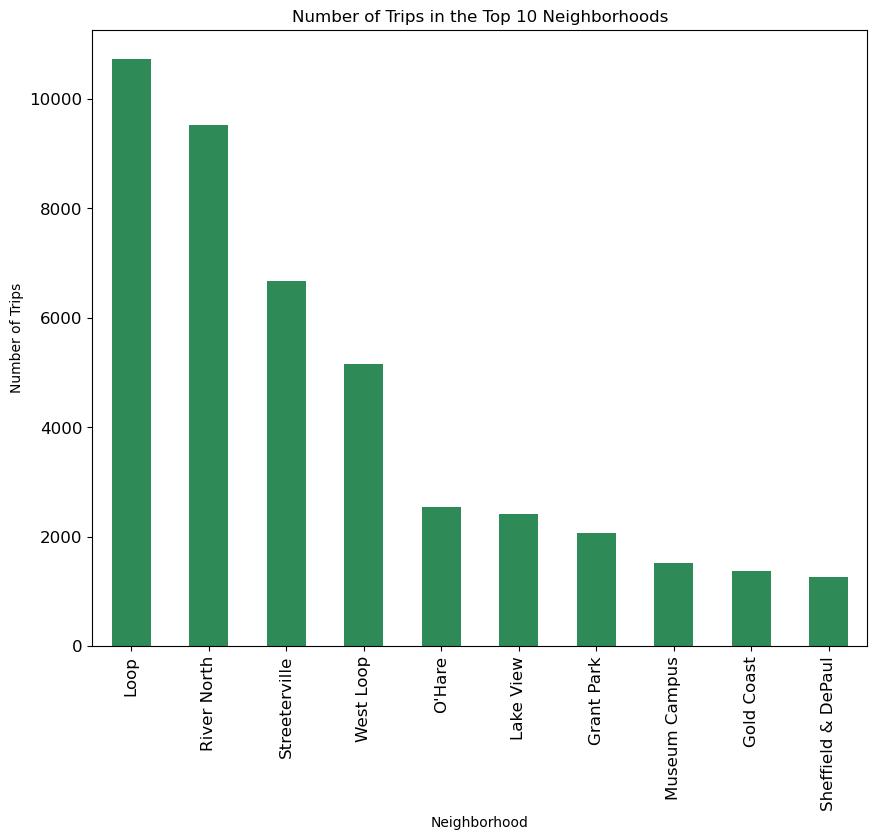

In [13]:
# Plot top 10 neighborhoods & number of rides

top_10_dropoff_locations_df.plot(kind='bar', x='dropoff_location_name', y='average_trips', figsize=(10,8), legend=False, title='Number of Trips in the Top 10 Neighborhoods', ylabel='Number of Trips', xlabel='Neighborhood', color='seagreen', fontsize=12)
plt.show()

**Observations**

In the Chicago area, two distinct dropoff locations stand out as particularly popular: the Loop and River North. Situated in Downtown Chicago, it's unsurprising that these areas boast the highest number of dropoff locations. The number of rides to these destinations shows minimal deviation, with the Loop seeing just over 10,000 rides and River North slightly below 10,000. However, there's a significant drop in ride counts after River North, with Streeterville being the next closest, tallying approximately 6,500 rides. The popularity dwindles further down the list, with the 10th most popular location, Sheffield & DePaul, accumulating only about 2,000 rides.

In [14]:
# Determining the taxi company
trips_df['company_name'].nunique()

64

In [15]:
# Creating DFs for each band (1-20, 21-40, 41-64)
company_top_32_df = trips_df.groupby('company_name')['trips_amount'].sum().sort_values(ascending=False).iloc[0:32].reset_index()
company_32_64_df = trips_df.groupby('company_name')['trips_amount'].sum().sort_values(ascending=False).iloc[33:64].reset_index()


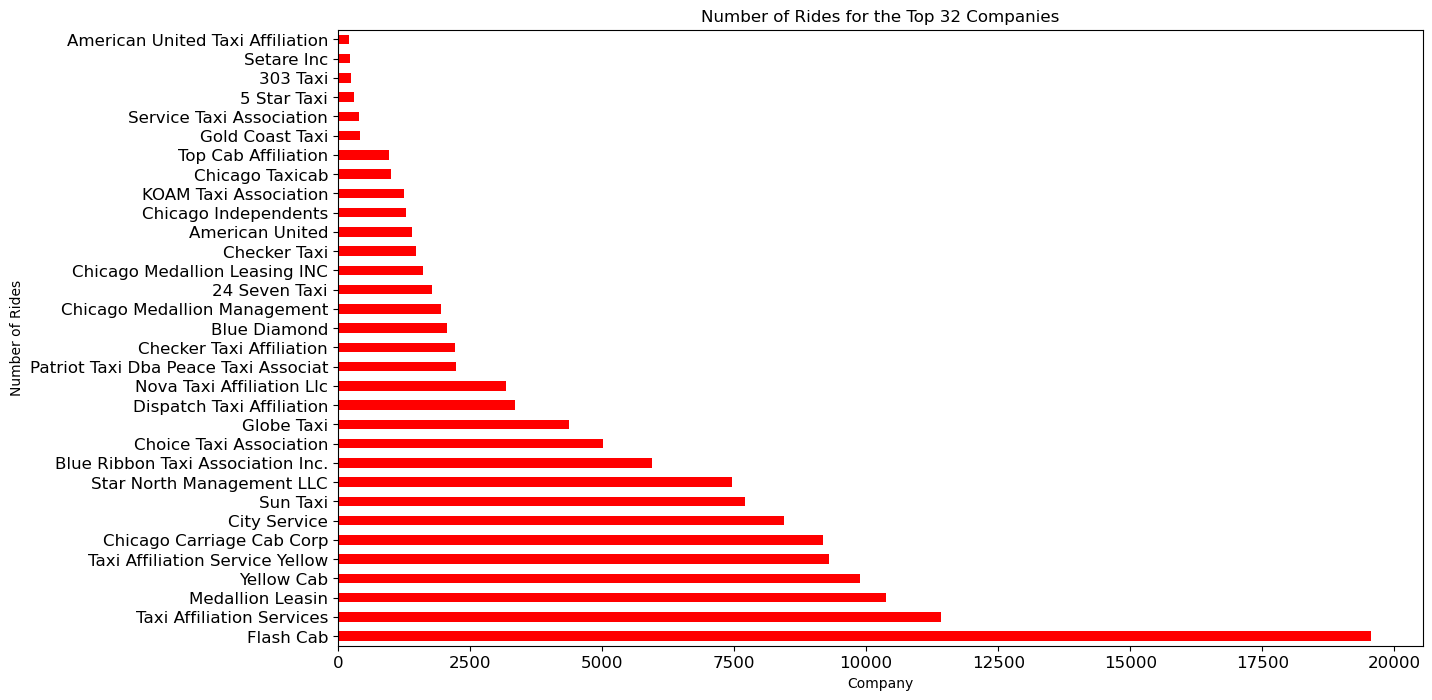

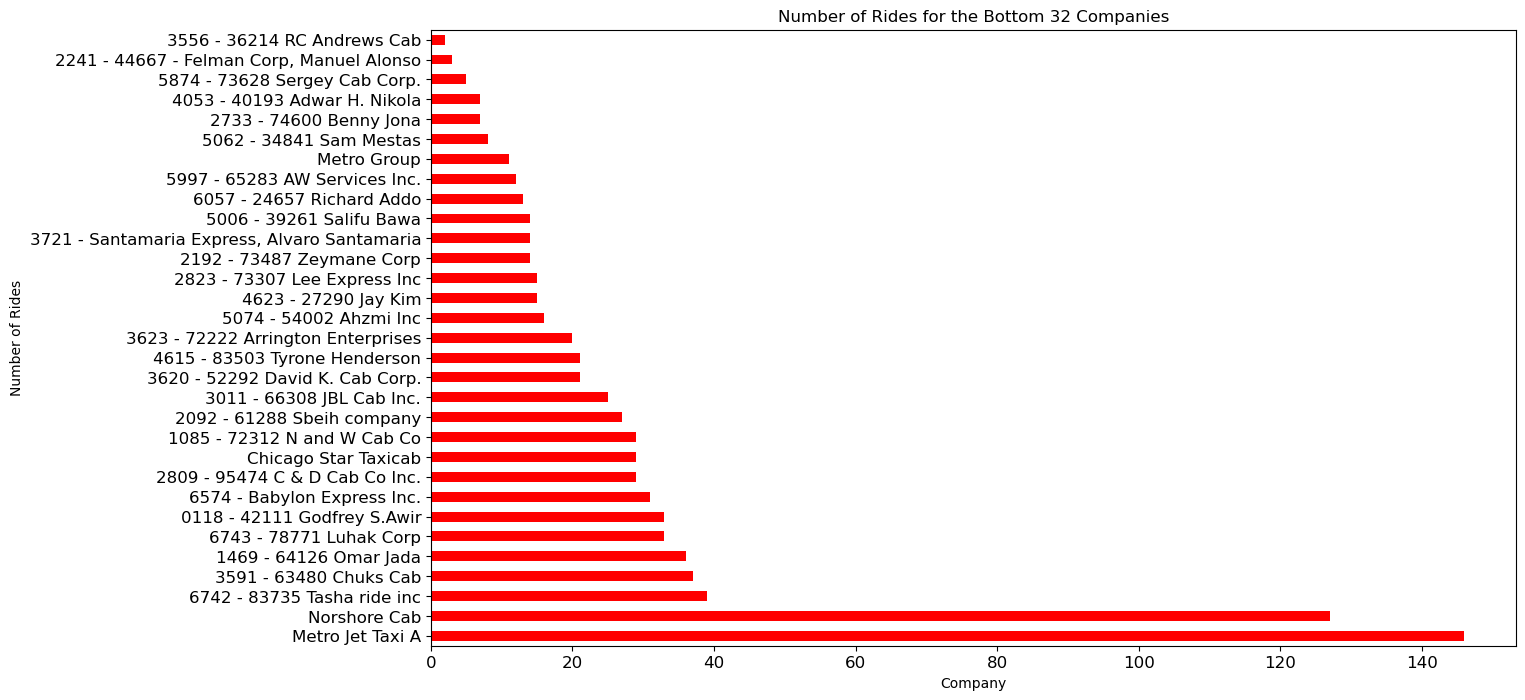

In [16]:
# Plotting numbe of rides for each company

dataframes_companies = [company_top_32_df, company_32_64_df]
titles = ['Number of Rides for the Top 32 Companies', 'Number of Rides for the Bottom 32 Companies']

for df, titles in zip(dataframes_companies, titles):
    df.plot(kind='barh', x='company_name', y='trips_amount', figsize=(14,8), xlabel='Company', ylabel='Number of Rides', legend=False, color='red', fontsize=12, title=titles)
    

**Observations**

Flash Cab emerges as the dominant force in the market, amassing nearly 20,000 rides, far surpassing its competitors. The next leading company, Taxi Affiliation Services, trails behind with approximately 12,500 rides. Subsequently, the subsequent eight companies exhibit comparable ride counts among themselves. However, it's crucial to highlight that the bottom 32 companies each register fewer than 140 rides, signifying their limited presence in the market.

## Hypothesis Testing

### Testing if the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

**Null Hypothesis:**

H0: μRainy = μOverall
- μRainy = represents the average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays.
- μOverall = represents the overall average duration of rides from the Loop to O'Hare International Airport, regardless of weather conditions.

**Alternate Hypothesis:**
H1: μRainy ≠ μOverall

**Alpha Value:**
- 5% (0.05)

**Explanation:**
- The null hypothesis states that there is no difference in the average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays compared to the overall average duration. Meanwhile, the alternate hypothesis claims that that there is a difference in duration from the Loop to O'Hare on rainy Saturdays.

In [17]:
# Gathering two samples based on the two conditions

bad_conditions = loop_ohare_df[loop_ohare_df['weather_conditions'] == 'Bad']['duration_seconds'].to_list()
good_conditions = loop_ohare_df[loop_ohare_df['weather_conditions'] == 'Good']['duration_seconds'].to_list()

In [18]:
# Conduting the hypthesis two-tailed test at 5%

alpha_05 = 0.05
alpha_01 = 0.01

_, pvalue = st.ttest_ind(bad_conditions, good_conditions)

print(f"The pvalue: {pvalue}")

if pvalue < alpha_05:
    print(f"We reject the null hypothesis at a {alpha_05} at 5% significance level")
else: 
    print(f"We can't reject the null hypothesis at a {alpha_05} at 5% significance level")
    
if pvalue < alpha_01:
    print(f"We reject the null hypothesis at a {alpha_01} at 1% significance level")
else: 
    print(f"We can't reject the null hypothesis at a {alpha_01} at 1% significance level")

The pvalue: 6.517970327099473e-12
We reject the null hypothesis at a 0.05 at 5% significance level
We reject the null hypothesis at a 0.01 at 1% significance level


**Observations**

The outcomes of the two-tailed hypothesis t-test indicate the rejection of the null hypothesis at both 1% and 5% significance levels. This finding implies a notable disparity in the duration of rides from the Loop to O'Hare on rainy Saturdays. The evidence suggests that there is  Employing two distinct alpha values, including the stricter 1% level, underscores the robustness of the analysis, reaffirming the rejection of the null hypothesis with compelling evidence.

## Conclusion

Through a comprehensive analysis of taxi trip data in Chicago, we have uncovered valuable insights into various aspects of the city's transportation landscape. Our investigation revealed distinct patterns and trends, shedding light on key factors influencing ride distribution, popular destinations, market dominance, and the impact of weather conditions on ride durations.

Firstly, our examination of company performance unveiled notable disparities, with Flash Cab emerging as the dominant player, significantly surpassing its competitors in terms of ride volume. This dominance was particularly evident in comparison to the bottom-tier companies, which exhibited minimal presence in the market.

Furthermore, our exploration of popular dropoff locations highlighted the prominence of the Loop and River North, both located in Downtown Chicago. While these areas consistently attracted a high volume of rides, there was a significant dropoff in popularity beyond River North, with Streeterville and subsequent locations registering notably lower ride counts.

In addition, our investigation into ride durations from the Loop to O'Hare International Airport revealed intriguing findings regarding the impact of rainy weather. Statistical analysis, including a two-tailed hypothesis t-test, provided compelling evidence of a significant difference in ride durations between rainy and non-rainy Saturdays. This suggests that weather conditions play a notable role in influencing travel times in the city.

Employing two distinct alpha values, including the more stringent 1% level, added rigor to our analysis and reaffirmed the robustness of our conclusions. The consistent rejection of the null hypothesis across different significance levels underscores the reliability of our findings.

In summary, our project provides valuable insights for taxi service providers, policymakers, and consumers alike. By understanding the dynamics of Chicago's taxi industry, stakeholders can make informed decisions to enhance service efficiency, improve customer experience, and optimize transportation strategies in the city.